## Wetting Ridge fit

### Shanahan Model
10.1021/la00004a055

$$\begin{equation*}
\zeta = \cfrac{\gamma_l\sin\theta}{2\pi G}\ln\left(\cfrac{d}{|x|}\right)
\end{equation*}$$

### Limat Model
10.1140/epje/i2012-12134-6

$$\begin{equation*}
\begin{split}
\zeta_S &= \cfrac{\gamma_l\sin\theta}{2\pi G}\left[\cfrac{l_S+x}{R}\log\cfrac{l_S+x+R}{l_S+x-R}-2\right],\hspace{1em} \mathrm{for} \hspace{1em} x>R\\
\zeta_S &= \cfrac{\gamma_l\sin\theta}{2\pi G}\left[\cfrac{l_S}{R}\log\cfrac{l_S+x+R}{l_S} + \cfrac{l_S}{R}\log\cfrac{l_S-x+R}{l_S}+\cfrac{x}{R}\log\cfrac{l_S+x+R}{l_S-x+R}-2\right], \hspace{1em} \mathrm{for} \hspace{1em} 0<x<R\\
\end{split}
\end{equation*}$$

$l_S = \cfrac{\gamma_S}{\pi G}$

### Style and Dufresne Model
10.1039/C2SM25540E  

#### Large Droplets on thin substrate

$\overline{x} = \frac{r-R}{h} $, 
$\overline{s} = sh$

$\nu = 0.5, G\approx\frac{E}{3} \rightarrow$  
$$\begin{equation*}
\begin{split}
\displaystyle u_z(\overline{x})
&= \cfrac{ \gamma_l }{2\pi G} \cdot \intop_0^\infty d\overline{s} \cfrac{\cos (\overline{sx})}{{\cfrac{1+2\overline{s}²+\cosh(2\overline{s})}{\sinh(2\overline{s})-2\overline{s}}\overline{s}+ \cfrac{\varUpsilon_s}{2Gh}\overline{s}^2}}\\
& =  \cfrac{ \gamma_l }{2\pi G} \cdot \intop_0^\infty d\overline{s} \cfrac{\cos (\overline{sx})}{{\cfrac{(1+2\overline{s}²)e^{-2\overline{s}}+\frac{1}{2}(1+e^{-4\overline{s}})}{\frac{1}{2}(1-e^{-4\overline{s}})-2\overline{s}e^{-2\overline{s}}}\overline{s}+ \cfrac{\varUpsilon_s}{2Gh}\overline{s}^2}}
\end{split}
\end{equation*}$$

#### General Asymmetric Form

$\nu = 0.5, G\approx\frac{E}{3}, z=h \rightarrow$  

$$\begin{equation*}
\begin{split}
u_z(\overline{x}) 
&= \gamma_l \intop_0^\infty ds \left[RJ_0(sR)-2\cfrac{J_1(sR)}{s}\right] \cfrac{3}{2sE} \left(\cfrac{1+2s²h²+\cosh(2sh)}{\sinh(2sh)-2sh}+ \cfrac{\varUpsilon_s}{2G}s\right)^{-1}\\ 
&= \gamma_l \intop_0^\infty ds \left[RJ_0(sR)-2\cfrac{J_1(sR)}{s}\right] \cfrac{3}{2sE} \left(\cfrac{(1+2s²h²)e^{-2sh}+\frac{1}{2}(1+e^{-4sh})}{\frac{1}{2}(1-e^{-4sh})-2she^{-2sh}}+ \cfrac{\varUpsilon_s}{2G}s\right)^{-1} 
\end{split}
\end{equation*}
$$

$h$: Substrate thickness,    $R$: Droplet radius, $\nu$: Poisson ratio,    $\gamma_l$: liquid vapour surface tension  
$\varUpsilon_s$: solid surface stress,   $E$: Elastic modulus,   $G$: Shear moulus  
$J_0, J_1$: Bessel functions of the first kind

In [6]:
import numpy as np
import cupy as cp
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
from util import RidgeFit, RidgeFitMethod


from models import style_exact, style_ld_ts, shanahan, limat_symmetric

def fit_profile(file, gamma, upsilon, gamma_s, theta, E_lookup, h):

    profile = pd.read_csv(file, sep=";", skiprows=3, names=["x","y","idk"], index_col=False)
    Fe, G, vol, _ = Path(file).stem.split("_")

    E = E_lookup[f"{Fe}_{G}"]

    defl = np.asarray(profile["y"], dtype=np.float64)[50:]
    x_ax = np.asarray(profile["x"], dtype=np.float64)[50:]
    R = x_ax[np.argmax(defl[100:])+100]

    peak = np.argmax(defl)
    x_ax += R - x_ax[peak]

    def fit_wrap(func):
        def f(x, p1, p2, p3):
            return func(x, gamma, R, p1, p2, p3)
        return f
    
    fits = dict()
    
    print(f"{Fe}_{G}_{vol} - {R*1000:.1f}")

    popt, pcov = curve_fit(fit_wrap(shanahan), x_ax, defl, p0=(theta, 1, E), bounds=([0,-np.inf,0],[180,np.inf,np.inf]))
    fits["shanahan"] = RidgeFit(x_ax, defl, vol, R, G, Fe, gamma, RidgeFitMethod.SHANAHAN, shanahan, popt, pcov)
    print(f"Shanahan:\tR2 {fits["shanahan"].r2:.3f}")

    popt, pcov = curve_fit(fit_wrap(limat_symmetric), x_ax, defl, p0=(gamma_s, theta, E), bounds=([0,0,0],[np.inf,180,np.inf]))
    fits["limat"] = RidgeFit(x_ax, defl, vol, R, G, Fe, gamma, RidgeFitMethod.LIMAT, limat_symmetric, popt, pcov)
    print(f"Limat:\t\tR2 {fits["limat"].r2:.3f}")

    popt, pcov = curve_fit(fit_wrap(style_ld_ts), x_ax, defl, p0=(upsilon, E, h), bounds=([0,0,0],[np.inf,np.inf,np.inf]))
    fits["style_ld"] = RidgeFit(x_ax, defl, vol, R, G, Fe, gamma, RidgeFitMethod.STYLE_LD, style_ld_ts, popt, pcov)
    print(f"Style R>>h:\tR2 {fits["style_ld"].r2:.3f}")

    popt, pcov = curve_fit(fit_wrap(style_exact), x_ax, defl, p0=(upsilon, E, h), bounds=([0,0,0],[np.inf,np.inf,np.inf]))
    fits["style"] = RidgeFit(x_ax, defl, vol, R, G, Fe, gamma, RidgeFitMethod.STYLE_LD, style_exact, popt, pcov)
    print(f"Style:\t\tR2 {fits["style"].r2:.3f}")
    print()

    return fits
    # plot fit
    # return Fit(x_ax, defl, vol, R, G, Fe, popt_sha, perr_sha, popt_lim_sym, perr_lim_sym,
    #            popt_ld_ts, perr_ld_ts, popt_hemi, perr_hemi)



In [8]:
from pathlib import Path
import pickle


# R= 0.0002
upsilon = 0.06 # from 10.1002/marc.202000360
gamma = 0.072 # from https://en.wikipedia.org/wiki/Surface_tension

initial_params = {\
    "h" : 0.001,
    "E_lookup" : {"70_S":5000,"70_H":10000,"80_S":15000,"80_H":30000},
    "upsilon" : 0.059, # from 10.1002/marc.202000360
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    "gamma_s": 0.021, # 10.1038/ncomms5369, 10.1103/PhysRevLett.109.038001
    "theta": 100
}

files = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_test").rglob("*_f.csv")

fit_params = dict()
for f in files:
    fit_params[str(f)] = fit_profile(f, **initial_params)


with open(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_first\fit_data.p","wb") as f:
    pickle.dump(fit_params, f, protocol=pickle.HIGHEST_PROTOCOL)

files = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_second\radial_prof").rglob("*2_f.csv")

fit_params = dict()
for f in files:
    fit_params[str(f)] = fit_profile(f, **initial_params)

with open(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_second\fit_data.p","wb") as f:
    pickle.dump(fit_params, f, protocol=pickle.HIGHEST_PROTOCOL)


70_H_2 - 0.9
Shanahan:	R2 -3.375
Limat:		R2 -1.645
Style R>>h:	R2 -5.015
Style:		R2 -1.893

70_S_2 - 0.8
Shanahan:	R2 0.551
Limat:		R2 0.267
Style R>>h:	R2 0.520
Style:		R2 0.864

80_H_2 - 0.9
Shanahan:	R2 -2.277
Limat:		R2 -1.247
Style R>>h:	R2 -0.993
Style:		R2 -1.538

80_S_2 - 0.8
Shanahan:	R2 0.874
Limat:		R2 0.329
Style R>>h:	R2 0.833
Style:		R2 0.225

70_H_2 - 0.9
Shanahan:	R2 0.362
Limat:		R2 -1.642
Style R>>h:	R2 -6.004
Style:		R2 -2.070

70_S_2 - 0.8
Shanahan:	R2 0.472
Limat:		R2 0.098
Style R>>h:	R2 0.541
Style:		R2 0.804

80_H_2 - 0.9
Shanahan:	R2 0.290
Limat:		R2 -0.479
Style R>>h:	R2 -0.187
Style:		R2 -0.722

80_S_2 - 0.8
Shanahan:	R2 0.788
Limat:		R2 0.298
Style R>>h:	R2 0.821
Style:		R2 0.609



In [10]:
import pickle
from IPython.display import display, Markdown

with open(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_first\fit_data.p","rb") as f:
    fit_params: dict[str, dict[str,RidgeFit]] = pickle.load(f)

sha_md = ["| Sample | d | 𝜃 | E | R2 |","| --- | --- | --- | --- | --- |"]
lim_md = ["| Sample | 𝛾ₛ | 𝜃 | E |R2 |","| --- | --- | --- | --- | --- |"]
st_ld_md = ["| Sample | 𝛶ₛ | h | E |R2 |","| --- | --- | --- | --- | --- |"]
st_ex_md = ["| Sample | 𝛶ₛ | h | E | R2 |","| --- | --- | --- | --- | --- |"]

for fit_name, ridgefit in fit_params.items():
    fit = ridgefit["shanahan"]
    popt, perr = fit.popt, fit.perr
    sha_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[1]:1.4e}±{perr[1]:1.2e}|{popt[0]:.1f}±{perr[0]:.1f}°|{popt[2]:.1f}±{perr[2]:.1f} Pa|{fit.r2}")
    fit = ridgefit["limat"]
    popt, perr = fit.popt, fit.perr
    lim_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[0]:.4f}±{perr[0]:.4f} N/m|{popt[1]:.1f}±{perr[1]:.1f}°|{popt[2]:.1f}±{perr[2]:.1f} Pa|{fit.r2}")
    fit = ridgefit["style_ld"]
    popt, perr = fit.popt, fit.perr
    st_ld_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[0]:.4f}±{perr[0]:.4f} N/m|{popt[2]*1000:.3f}±{perr[2]*1000:.3f} mm|{popt[1]:.1f}±{perr[1]:.1f} Pa|{fit.r2}")
    fit = ridgefit["style"]
    popt, perr = fit.popt, fit.perr
    st_ex_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[0]:.4f}±{perr[0]:.4f} N/m|{popt[2]*1000:.3f}±{perr[2]*1000:.3f} mm|{popt[1]:.1f}±{perr[1]:.1f} Pa|{fit.r2}")

sha_md = "\n".join(sha_md)
lim_md = "\n".join(lim_md)
st_ld_md = "\n".join(st_ld_md)
st_ex_md = "\n".join(st_ex_md)

display(Markdown("## Shanahan\n\n" + sha_md + "\n## Limat\n\n" + lim_md + "\n## Style\n### R>>h\n" + st_ld_md + "\n### exact\n" + st_ex_md))
    

## Shanahan

| Sample | d | 𝜃 | E | R2 |
| --- | --- | --- | --- | --- |
|70_H_2|1.8596e-04±3.08e-06|100.1±4.8°|19144.6±0.1 Pa|-3.3751303616302826
|70_S_2|2.7194e-04±3.96e-06|85.3±9.5°|4119.6±1.6 Pa|0.5512006339521278
|80_H_2|6.3435e-04±2.10e-05|101.9±6.4°|30000.0±0.1 Pa|-2.277226102890683
|80_S_2|3.6998e-04±2.57e-06|101.3±1.9°|14999.5±0.0 Pa|0.8739421247643745
## Limat

| Sample | 𝛾ₛ | 𝜃 | E |R2 |
| --- | --- | --- | --- | --- |
|70_H_2|0.0077±0.0095 N/m|100.0±5.5°|36669.0±0.0 Pa|-1.6448688551019388
|70_S_2|0.0125±5986.7987 N/m|97.3±213255185.9°|6634.1±3181187655.5 Pa|0.2669249069862396
|80_H_2|0.0210±7968.7074 N/m|100.0±123302782.7°|30000.0±11383880327.1 Pa|-1.2469270347962755
|80_S_2|0.0210±7052.2103 N/m|100.0±109121531.6°|15000.0±5037301049.3 Pa|0.32926908965952995
## Style
### R>>h
| Sample | 𝛶ₛ | h | E |R2 |
| --- | --- | --- | --- | --- |
|70_H_2|0.0375±0.0166 N/m|0.996±0.001 mm|20000.0±402.7 Pa|-5.014724169204003
|70_S_2|0.0028±0.0015 N/m|0.942±0.000 mm|4340.3±69.2 Pa|0.5204340364677504
|80_H_2|0.0590±0.0264 N/m|1.000±0.001 mm|30000.0±625.5 Pa|-0.9932427170622302
|80_S_2|0.0590±0.0080 N/m|1.000±0.001 mm|15000.0±137.1 Pa|0.8327933058196024
### exact
| Sample | 𝛶ₛ | h | E | R2 |
| --- | --- | --- | --- | --- |
|70_H_2|0.0080±0.0124 N/m|0.990±0.058 mm|36567.1±1148.5 Pa|-1.892646799642392
|70_S_2|0.0603±0.0011 N/m|0.076±0.003 mm|137.6±13.0 Pa|0.8636857134937806
|80_H_2|0.0590±0.0323 N/m|1.000±0.057 mm|30000.0±1056.9 Pa|-1.5376555680207118
|80_S_2|0.1793±0.0674 N/m|0.825±0.065 mm|20893.1±1322.0 Pa|0.22455449939105554

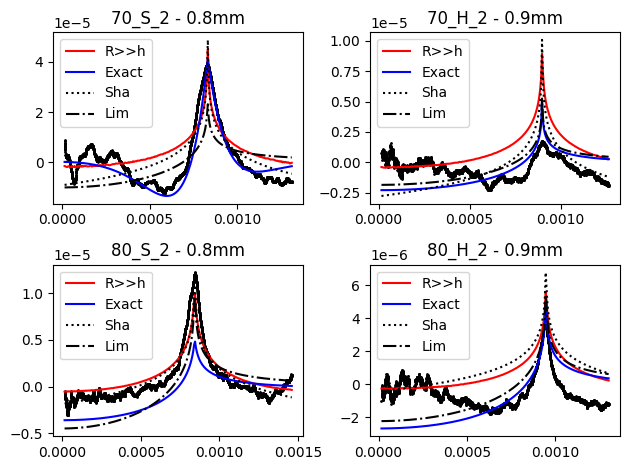

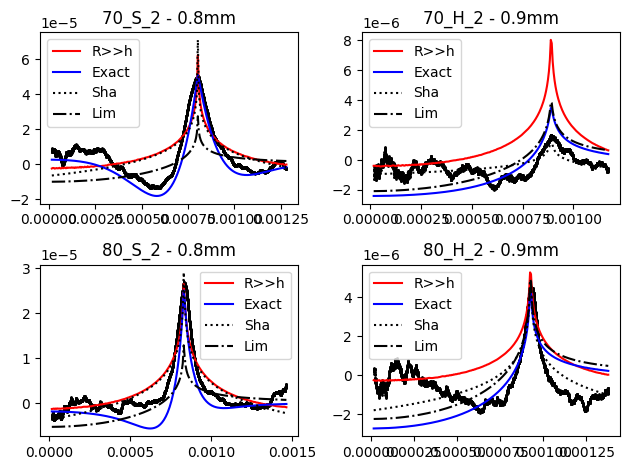

In [9]:
import pickle

with open(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_first\fit_data.p","rb") as f:
    fit_params: dict[str, dict[str, RidgeFit]] = pickle.load(f)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,2)
i=0
for fit_name, fit in fit_params.items():
    
    # drop, popt_ld_ts, popt_hemi, pcov_ld_ts, pcov_hemi, x_ax, defl = fit
    # vol, R, G, Fe = drop
    i = 0 if fit["style"].shear_mod == "S" else 1
    j = 0 if fit["style"].iron_content == "70" else 1
    plt.sca(ax[j,i])
    fit_x = np.linspace(fit["style"].x_values.min(), fit["style"].x_values.max(), 250)

    plt.plot(fit["style"].x_values, fit["style"].y_values,"k.", markersize=2)
    rf = fit["style_ld"]
    plt.plot(fit_x, style_ld_ts(fit_x, rf.gamma, rf.radius, *rf.popt), "r-", label='R>>h')
    rf = fit["style"]
    plt.plot(fit_x, style_exact(fit_x, rf.gamma, rf.radius, *rf.popt), "b-", label="Exact")
    rf = fit["shanahan"]
    plt.plot(fit_x, shanahan(fit_x, rf.gamma, rf.radius, *rf.popt), "k:", label="Sha")
    rf = fit["limat"]
    plt.plot(fit_x, limat_symmetric(fit_x, rf.gamma, rf.radius, *rf.popt), "k-.", label="Lim")
    r = fit["style"].radius*1000
    plt.title(f"{fit["style"].iron_content}_{fit["style"].shear_mod}_{fit["style"].volume} - {r:.1f}mm")
    plt.legend()
    i+=1

plt.tight_layout()
plt.show()

with open(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_second\fit_data.p","rb") as f:
    fit_params: dict[str, dict[str, RidgeFit]] = pickle.load(f)

fig, ax = plt.subplots(2,2)
i=0
for fit_name, fit in fit_params.items():
    
    # drop, popt_ld_ts, popt_hemi, pcov_ld_ts, pcov_hemi, x_ax, defl = fit
    # vol, R, G, Fe = drop
    i = 0 if fit["style"].shear_mod == "S" else 1
    j = 0 if fit["style"].iron_content == "70" else 1
    plt.sca(ax[j,i])
    fit_x = np.linspace(fit["style"].x_values.min(), fit["style"].x_values.max(), 250)

    plt.plot(fit["style"].x_values, fit["style"].y_values,"k.", markersize=2)
    rf = fit["style_ld"]
    plt.plot(fit_x, style_ld_ts(fit_x, rf.gamma, rf.radius, *rf.popt), "r-", label='R>>h')
    rf = fit["style"]
    plt.plot(fit_x, style_exact(fit_x, rf.gamma, rf.radius, *rf.popt), "b-", label="Exact")
    rf = fit["shanahan"]
    plt.plot(fit_x, shanahan(fit_x, rf.gamma, rf.radius, *rf.popt), "k:", label="Sha")
    rf = fit["limat"]
    plt.plot(fit_x, limat_symmetric(fit_x, rf.gamma, rf.radius, *rf.popt), "k-.", label="Lim")
    r = fit["style"].radius*1000
    plt.title(f"{fit["style"].iron_content}_{fit["style"].shear_mod}_{fit["style"].volume} - {r:.1f}mm")
    plt.legend()
    i+=1

plt.tight_layout()
plt.show()